## Pandas的stack和pivot实现数据透视


<img src="./other_files/reshaping_example.png" style="margin-left:0px; width:600px" />

1. 经过统计得到多维度指标数据
2. 使用unstack实现数据二维透视
3. 使用pivot简化透视
4. stack、unstack、pivot的语法

###  1. 经过统计得到多维度指标数据

非常常见的统计场景，指定多个维度，计算聚合后的指标  

实例：统计得到“电影评分数据集”，每个月份的每个分数被评分多少次：（月份、分数1~5、次数）

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv(
    "./datas/movielens-1m/ratings.dat",
    header=None,
    names="UserID::MovieID::Rating::Timestamp".split("::"),
    sep="::",
    engine="python"
)

In [3]:
df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df["pdate"] = pd.to_datetime(df["Timestamp"], unit='s')

In [5]:
df.head()

,UserID,MovieID,Rating,Timestamp,pdate
0,1,1193,5,978300760,2000-12-31 22:12:40
1,1,661,3,978302109,2000-12-31 22:35:09
2,1,914,3,978301968,2000-12-31 22:32:48
3,1,3408,4,978300275,2000-12-31 22:04:35
4,1,2355,5,978824291,2001-01-06 23:38:11


In [6]:
df.dtypes

UserID                int64
MovieID               int64
Rating                int64
Timestamp             int64
pdate        datetime64[ns]
dtype: object

In [7]:
# 实现数据统计
df_group = df.groupby([df["pdate"].dt.month, "Rating"])["UserID"].agg(pv=np.size)

In [8]:
df_group.head(20)

pv
pdate Rating      
1     1       1127
      2       2608
      3       6442
      4       8400
      5       4495
2     1        629
      2       1464
      3       3297
      4       4403
      5       2335
3     1        466
      2       1077
      3       2523
      4       3032
      5       1439
4     1       1048
      2       2247
      3       5501
      4       6748
      5       3863

对这样格式的数据，我想查看按月份，不同评分的次数趋势，是没法实现的

需要将数据变换成每个评分是一列才可以实现

### 2. 使用unstack实现数据二维透视

目的：想要画图对比按照月份的不同评分的数量趋势

In [9]:
df_stack = df_group.unstack()
df_stack

pv                             
Rating      1      2      3       4      5
pdate                                     
1        1127   2608   6442    8400   4495
2         629   1464   3297    4403   2335
3         466   1077   2523    3032   1439
4        1048   2247   5501    6748   3863
5        4557   7631  18481   25769  17840
6        3196   6500  15211   21838  14365
7        4891   9566  25421   34957  22169
8       10873  20597  50509   64198  42497
9        3107   5873  14702   19927  13182
10       2121   4785  12175   16095  10324
11      17701  32202  76069  102448  67041
12       6458  13007  30866   41156  26760

<Axes: xlabel='pdate'>

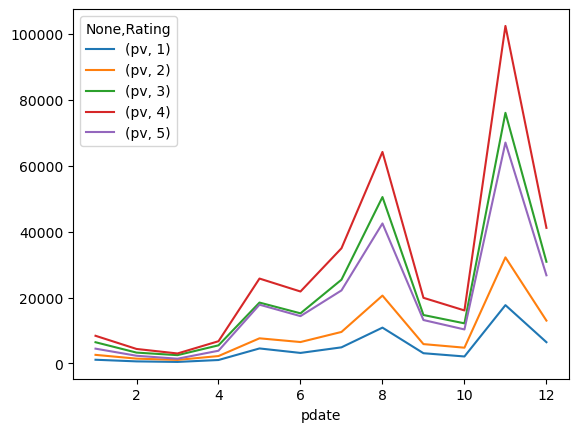

In [10]:
df_stack.plot()

In [11]:
# unstack和stack是互逆操作
df_stack.stack().head(20)

pv
pdate Rating      
1     1       1127
      2       2608
      3       6442
      4       8400
      5       4495
2     1        629
      2       1464
      3       3297
      4       4403
      5       2335
3     1        466
      2       1077
      3       2523
      4       3032
      5       1439
4     1       1048
      2       2247
      3       5501
      4       6748
      5       3863

### 3. 使用pivot简化透视

In [12]:
df_group.head(20)

pv
pdate Rating      
1     1       1127
      2       2608
      3       6442
      4       8400
      5       4495
2     1        629
      2       1464
      3       3297
      4       4403
      5       2335
3     1        466
      2       1077
      3       2523
      4       3032
      5       1439
4     1       1048
      2       2247
      3       5501
      4       6748
      5       3863

In [13]:
df_reset = df_group.reset_index()
df_reset.head()

,pdate,Rating,pv
0,1,1,1127
1,1,2,2608
2,1,3,6442
3,1,4,8400
4,1,5,4495


In [14]:
df_pivot = df_reset.pivot(columns="pdate", index="Rating", values="pv")

In [15]:
df_pivot.head()

pdate,1,2,3,4,5,6,7,8,9,10,11,12
Rating,,,,,,,,,,,,
1,1127,629,466,1048,4557,3196,4891,10873,3107,2121,17701,6458
2,2608,1464,1077,2247,7631,6500,9566,20597,5873,4785,32202,13007
3,6442,3297,2523,5501,18481,15211,25421,50509,14702,12175,76069,30866
4,8400,4403,3032,6748,25769,21838,34957,64198,19927,16095,102448,41156
5,4495,2335,1439,3863,17840,14365,22169,42497,13182,10324,67041,26760


<Axes: xlabel='Rating'>

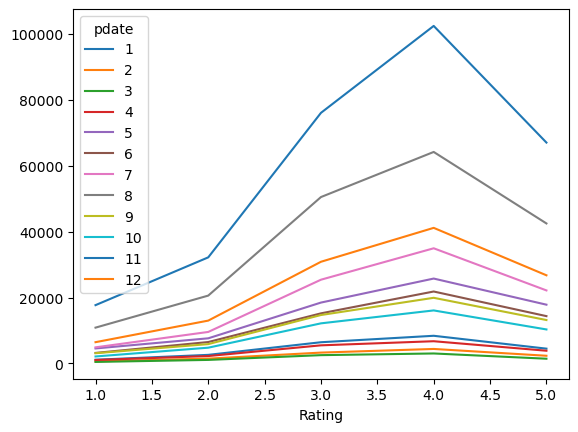

In [16]:
df_pivot.plot()

***pivot方法相当于对df使用set_index创建分层索引，然后调用unstack***

### 4. stack、unstack、pivot的语法

#### stack：DataFrame.stack(level=-1, dropna=True)，将column变成index，类似把横放的书籍变成竖放

level=-1代表多层索引的最内层，可以通过==0、1、2指定多层索引的对应层

<img src="./other_files/reshaping_stack.png" style="margin-left:0px; width:600px" />

#### unstack：DataFrame.unstack(level=-1, fill_value=None)，将index变成column，类似把竖放的书籍变成横放

<img src="./other_files/reshaping_unstack.png" style="margin-left:0px; width:600px" />

#### pivot：DataFrame.pivot(index=None, columns=None, values=None)，指定index、columns、values实现二维透视

<img src="./other_files/reshaping_pivot.png" style="margin-left:0px; width:600px" />